## CM50268 / CM30322

## Coursework Zero

# Playing the Slots (with Posteriors)

**This lab is not assessed.**


## Background

This coursework provides an exercise in computing posterior distributions, in the context of trying to maximise the "payout" of a "multi-armed bandit". (You may see this application again in one or more other units - it's related to problems in reinforcement learning.)

A $K$-armed bandit (a little like a slot machine) has $K$ levers, and you may choose which one to pull. Associated with each lever is some payout distribution, the parameters of which are unknown to you at the outset. The name of the "game" is to try and maximise your earnings across a fixed number of $N$ pulls (here, we try $N=100$).
 
A key question to consider at each pull is whether to "exploit" or "explore":
- **exploit:** choose to pull the lever that has proved most profitable so far, or
- **explore:** gather data from another lever and improve the state of knowledge.

Managing the "exploration-exploitation" trade-off is a key aspect in search and reinforcement learning. This lab will utilise a Bayesian approach (which isn't necessary the best to adopt, but demonstrates the principles).

## Supporting Code

First, download (from Moodle) and import the library "setup_cw0.py" which defines some *K*-armed bandits. This lab will focus on two of them:

- `BernoulliBandit` which pays out either Â£25 with unknown arm-dependent probability $\theta_k$, and nothing otherwise,
- `GammaBandit` which pays out a positive amount based on a Gamma distribution with fixed shape parameter $\alpha=5$ but unknown arm-dependent rate parameter $\beta_k$.

All bandits have a fixed cost of Â£10 to pull a lever. This dosen't affect strategy, but makes the earnings charts slightly more "realistic".

As well as the bandit definitions (imported), there is one piece of further code which is discussed shortly.


In [41]:
# Import the usual libraries, including scipy.stats (if needed)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Import the bandit classes
import setup_cw0 as setup
#

## Defining our algorithm

Second, we define below a function which runs the slot machine for a given number of pulls (default is 100). To utilise it, as well as one of the pre-defined "bandit" class instances, you also pass it a sub-class instance of a `Selector` (an example is given shortly), the base class for which is at the end of the "setup_cw0.py" library.

This derived class must define three methods: `lever_select()`, `update_state(lever, payback)` and `reset_state()`:

- `lever_select()` is your method to choose which lever to pull, and should return an integer from 0 to K-1
- `update_state(lever, payback)` is your method to update any internal memory, or state, as the result of receiving `payback` for pulling arm `lever`
- `reset_state()` is to initialise/reset the internal state (for the purposes of repeated assessments)

The class, of course, should also declare any internal state in its constructor.

The `run_selector(bandit, selector)` function below returns an array of size $N$ (default 100) containing the cumulative earnings at each point in time for `selector` playing on `bandit`.


In [42]:
#
# run_selector
#
# A function to test out a lever selection algorithm
#
cost = 10  # Adds realism, but doesn't affect strategy
#
def run_selector(bandit, selector, N=100):
    earnings = 0
    earnings_array = np.zeros(N)
    for n in range(N):
        # select-pull-update cycle
        lever = selector.lever_select()
        payout = bandit.pull(lever)
        selector.update_state(lever, payout)
        #
        earnings += (payout - cost)
        earnings_array[n] = earnings
    #
    return earnings_array
    

## An Example (Purely Random) Selector Algorithm: Exploration Only
Next we define a sample class, `RandomSelector`. It is state-less (has no memory) and very simple: it learns nothing from the outcomes of its strategy. It simply chooses a lever at random every time; in other words, it only "explores".

In [43]:
class RandomSelector(setup.Selector):

    def __init__(self, name, K):
        super().__init__(name, K)
        # No state
        
    def reset_state(self):
        # There is no state
        pass

    def update_state(self, lever, payout):
        # Nothing to do here
        pass

    def lever_select(self):
        #
        # Choose one purely at random
        # 
        lever = np.random.randint(self.K)
        return lever


## Assessing Earnings Performance

We now define a useful function `plot_performance()` for visualising the outcome of running our selection algorithms on any particular bandit. As well as graphing the cumulative earnings over time, it also plots (in grey dashes) the *expected* average earnings (if you chose levers at random) and the (higher) *expected* maximum earnings (if you had perfect knowledge and chose the best lever every time). Remember that these are "expected" earnings - even if you pull the best lever each time, the payback is still a random variable.

The function takes a `repeats` argument, which instructs it to average the earnings over that number of runs. It defaults to one, but we set `repeats=100` below when assessing overall performance (to average out the "lucky streaks"). It may take a few seconds to run.


In [44]:
def plot_performance(bandit, selectors_list, N=100, repeats=1, title=None):
    plt.figure(figsize=(10,8))
    final_scores = []
    overall_max = 0
    overall_mean = 0
    for selector in selectors_list:
        mean_earnings = np.zeros(N)
        for run in range(repeats):
            #
            bandit.reinitialise(run)  # Change the probabilities with updated seed
            selector.reset_state()
            #
            earnings = run_selector(bandit, selector, N)
            mean_earnings += earnings
            #
            overall_mean += (bandit.mean_return() - cost) * N
            overall_max += (bandit.max_return() - cost) * N
            #
        mean_earnings /= repeats
        plt.plot(range(N), mean_earnings, '-', label=selector.name)
        final_scores.append(mean_earnings[-1])
    #
    print("Final Earnings\n==============")
    for idx, score in enumerate(final_scores):
        print(f"Â£{score:.2f} <- {selectors_list[idx].name}")
    #
    # Plot theoretical mean (random choice) and maximum (clairvoyant) return
    #
    overall_mean /= (repeats * len(selectors_list))
    overall_max /= (repeats * len(selectors_list))
    plt.plot([0, N], [0, overall_mean], '--', color='silver')
    plt.plot([0, N], [0, overall_max], '--', color='silver')
    #
    plt.xlabel('Time Step')
    plt.ylabel('Cumulative Earnings')
    plt.legend(loc='best')
    plt.tick_params(right=True)
    if title is not None:
        plt.title(title)


## Random Selector Performance

We experiment with a `BernoulliBandit` first, with $K=6$ levers (you can of course experiment).

The code below applies the `plot_performance()` function  to assess the `RandomSelector` scheme. The earnings of the random selector should roughly coincide with the lower, dashed, expected average line (if averaged over sufficient repetitions). The default number of repetions here is 100, although 500-1000 would give smoother earnings curves (with more waiting time ...).


Final Earnings
Â£233.50 <- Random


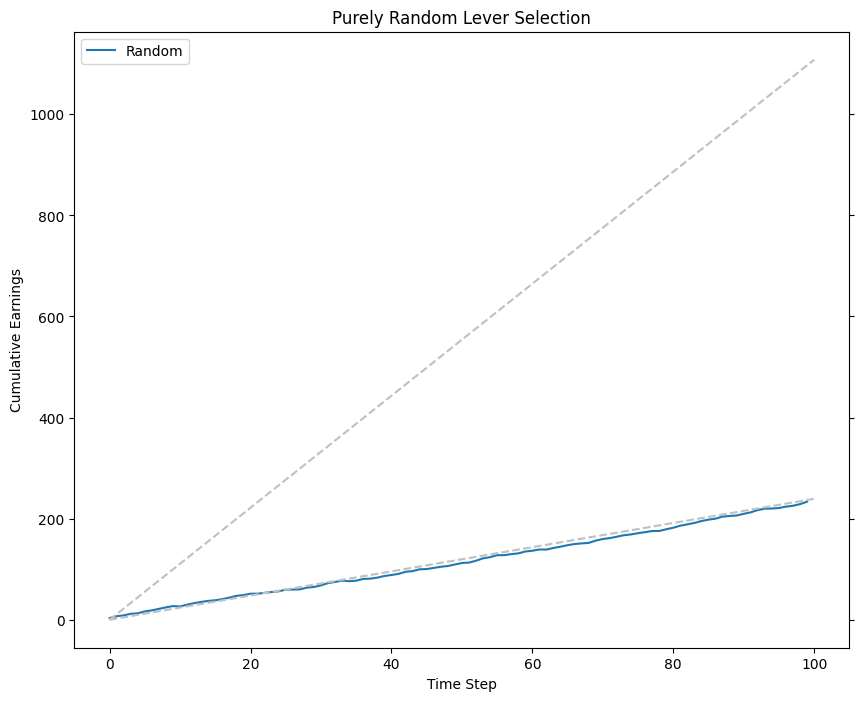

In [45]:
#### Test the random selector ####

# Define bandit with given random seed and set cost
#
seed = 0
num_levers = 6  # Arbitrary - feel free to experiment
jacob_bandit = setup.BernoulliBandit(arms=num_levers, seed=seed)

# Define selector
rand_select = RandomSelector(name="Random", K=num_levers)

# Create list of selectors to compare: here just the single Random one above
#
selectors = [rand_select]

# Pass bandit and selector to plot_performance() for assessment
# - average over 100 repetitions
#
repetitions = 100
plot_performance(jacob_bandit, selectors, N=100, repeats=repetitions,
                 title='Purely Random Lever Selection')

## A Slightly Smarter Algorithm: Some Exploration + Exploitation
The next piece of code defines a simple *stateful* lever selector. It tracks the average payout for each arm, choosing the highest average (exploiting) but then occasionally, with probability set by the argument `prob`, making an entirely random choice (exploring). This selector class also includes functionality for "annealing" the exploration probability (see below).

In [46]:
class BestMeanPlusSomeRandom(setup.Selector):
    
    def __init__(self, name, K, prob=0.2, decay=1.0):
        super().__init__(name, K)
        self._prob_explore_init = prob
        self._decay = decay
        # State: will be initialised in reset_state()
        self._prob_explore = None
        self._Totals = None
        self._Counts = None
        self._Means = None
        self.reset_state()
        
    def reset_state(self):
        # Reset back to start (allows repeated runs)
        self._Totals = np.zeros(self.K)
        self._Counts = np.zeros(self.K)
        self._Means = np.zeros(self.K)
        self._prob_explore = self._prob_explore_init
        
    def update_state(self, lever, payout):
        # Maintain running averages
        self._Counts[lever] += 1
        self._Totals[lever] += payout
        self._Means[lever] = self._Totals[lever] / self._Counts[lever]
        # Anneal the exploration (if decay<1)
        self._prob_explore *= self._decay
        
    def lever_select(self):
        if np.random.rand() < self._prob_explore:
            # Random choice
            lever = np.random.randint(self.K)
        else:
            # Highest mean
            lever = np.argmax(self._Means)
        return lever      
        
   

Now we can test the `BestMeanPlusSomeRandom` class, and compare against the purely random algorithm. We can test it with a fixed random exploration probability (0.2), and also with an "annealed" value. This starts off high (e.g. 1), but gradually reduces over time according to a decay rate. So early on it explores, but later, when it has a good estimate for the payout probabiliities, it will effectively only exploit (the exploration probability tends to zero). This is a rather heuristic approach, but with the right settings for the initial probability and the decay rate, this variant ought to provide the best earnings of the three. (You can of course experiment with the default parameter settings.)


Final Earnings
Â£253.25 <- Random
Â£696.00 <- Best mean + 20% random
Â£851.50 <- Best mean + 100% random (annealed 0.95)


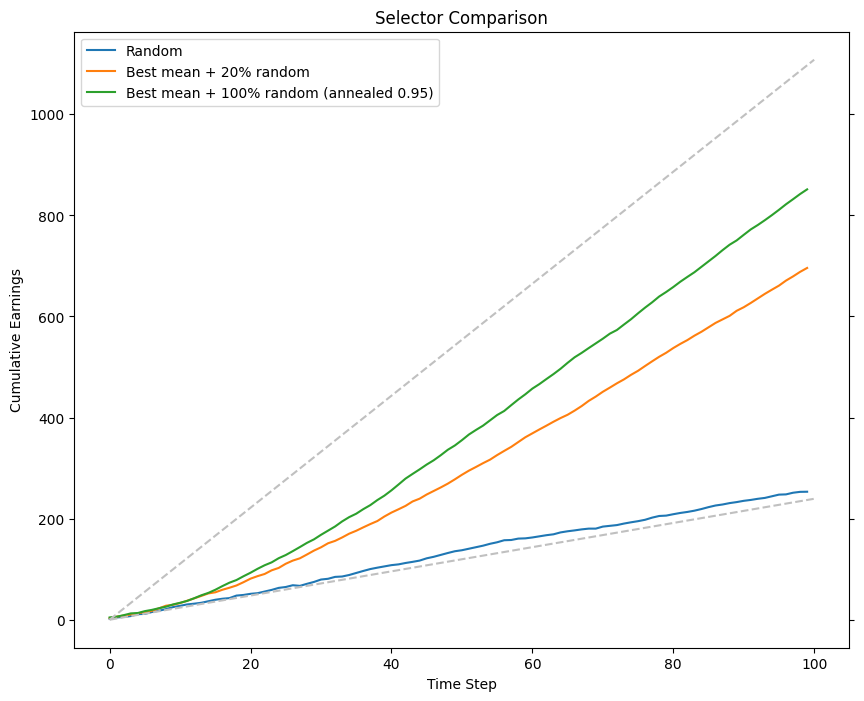

In [47]:
#
# Create list of selectors to compare
#
# 1.
rand_select = RandomSelector(name="Random", K=num_levers)
# 2.
p_random = 0.2
selector_name = f"Best mean + {p_random:.0%} random"
rand_best_mean_select = BestMeanPlusSomeRandom(name=selector_name, K=num_levers, prob=p_random)
# 3.
p_random = 1.0
anneal = 0.95
selector_name = f"Best mean + {p_random:.0%} random (annealed {anneal:.2f})"
rand_best_mean_annealed_select = BestMeanPlusSomeRandom(name=selector_name, K=num_levers, prob=p_random, decay=anneal)
#
selectors = [rand_select,
             rand_best_mean_select,
             rand_best_mean_annealed_select]

# Run Comparison
plot_performance(jacob_bandit, selectors, N=100, repeats=100, title='Selector Comparison')



# The Main Exercise: Build a Bayesian Selector

The exercise is to create your own Bayesian "selector" class(es) and try and maximise your earnings, over 100 pulls, for the `BernoulliBandit` (initially), and then the `GammaBandit` (later, a little trickier).


## The Bernoulli Bandit

The `BernoulliBandit` has $K$ levers, each of which pays out Â£25 with unknown probability $\theta_k$.

Suggested strategic approach:

1. Write a `BayesBernoulliSelector` class where the `update_state()` method tracks the posterior distribution of the payout probability of each individual lever.  You will need to make a choice of hyperparameters $\alpha_0$ and $\beta_0$ for the prior (which can be identical for each lever - no need to overcomplicate!)

2. Given the posterior distributions over $\theta_k$, devise a `lever_select()` method.

3. One suggested method would be:
    - randomly sample all $\hat\theta_k$ from the posteriors (use `stats.beta.rvs`)
    - choose the arm with highest random *sample* $\hat\theta_k$ value (which is *not* simply the highest posterior mean). Given the random sample, this will give the highest expected payout. After many pulls, these samples will of course converge on the true $\theta_k$
    - this approach is known as "Thompson sampling" (which you will probably meet elsewhere)

4. Compare your class against the `BestMeanPlusSomeRandom` variants above. (Code is in place below to do this.)

5. You might also wish to see if you can  beat the earnings of (3.) above with an alternative (heuristic) algorithm of your own devising, which may or may not be Bayesian.

I will post an example `BayesBernoulliSelector` part-way through the lab (see if you can improve on it).



## Recap

*The information you need is in the lecture notes and slides, and repeated here.*

Assuming you choose a conjugate prior over $\theta_k$, which is Beta($\alpha_0$, $\beta_0$), your posterior for arm $k$ after $N$ pulls is Beta($\alpha_N$, $\beta_N$) with

$$
\alpha_N = \alpha_0 + n_{1k},
$$
and
$$
\beta_N = \beta_0 + n_{0k},
$$

having defined $n_{1k}$ as the number of observed "successes" (positive payouts) when pulling arm $k$ and $n_{0k}$ as the number of observed "failures".

You will need to choose a single set of prior parameters $\alpha_0$ and $\beta_0$, and will need to track $K$ sets of posterior parameters $\alpha_N$ and $\beta_N$ within the `update_state()` method.

## Insert Your Code Below ...


In [48]:
# Write your BayesBernoulliSelector class here
        
# I will post a specimen example class later in the lab (currently commented out)

#### YOUR CODE HERE ####

class BayesBernoulliSelector(setup.Selector):
    
    def __init__(self, name, K, alpha_0=1, beta_0=1):
        super().__init__(name, K)
        self._alpha_0 = alpha_0  # Prior success count for each arm
        self._beta_0 = beta_0  # Prior failure count for each arm
        self.reset_state()

    def reset_state(self):
        # Initialize the posterior parameters for each arm
        self._alpha = np.full(self.K, self._alpha_0)
        self._beta = np.full(self.K, self._beta_0)

    def update_state(self, lever, payout):
        # Update the posterior distribution for the chosen arm based on the outcome
        if payout > 0:  # Success (positive payout)
            self._alpha[lever] += 1
        else:  # Failure (no payout)
            self._beta[lever] += 1

    def lever_select(self):
        # Sample from the posterior Beta distribution for each arm
        sampled_thetas = np.random.beta(self._alpha, self._beta)
        # Choose the arm with the highest sampled value
        lever = np.argmax(sampled_thetas)
        return lever

In [49]:
# The earlier assessment code is copied here, including the three variants of random selector.
#
# Add your `BayesBernoulliSelector` (and any other classes) to the testing list, and run
# (the code defaults to averaging earnings over 100 repetitions)
#

# Re-create the bandit
#
my_bandit = setup.BernoulliBandit(arms=num_levers, seed=seed)

#
# Create list of selectors to compare (first three as before)
#
# 1.
rand_select = RandomSelector(name="Random", K=num_levers)
# 2.
p_random = 0.2
selector_name = f"Best mean + {p_random:.0%} random"
rand_best_mean_select = BestMeanPlusSomeRandom(name=selector_name, K=num_levers, prob=p_random, )
# 3.
p_random = 1.0
anneal = 0.95
selector_name = f"Best mean + {p_random:.0%} random (annealed {anneal:.2f})"
rand_best_mean_annealed_select = BestMeanPlusSomeRandom(name=selector_name, K=num_levers, prob=p_random, decay=anneal)

Final Earnings
Â£249.00 <- Random
Â£724.75 <- Best mean + 20% random
Â£844.25 <- Best mean + 100% random (annealed 0.95)
Â£872.75 <- Bayes Bernoulli


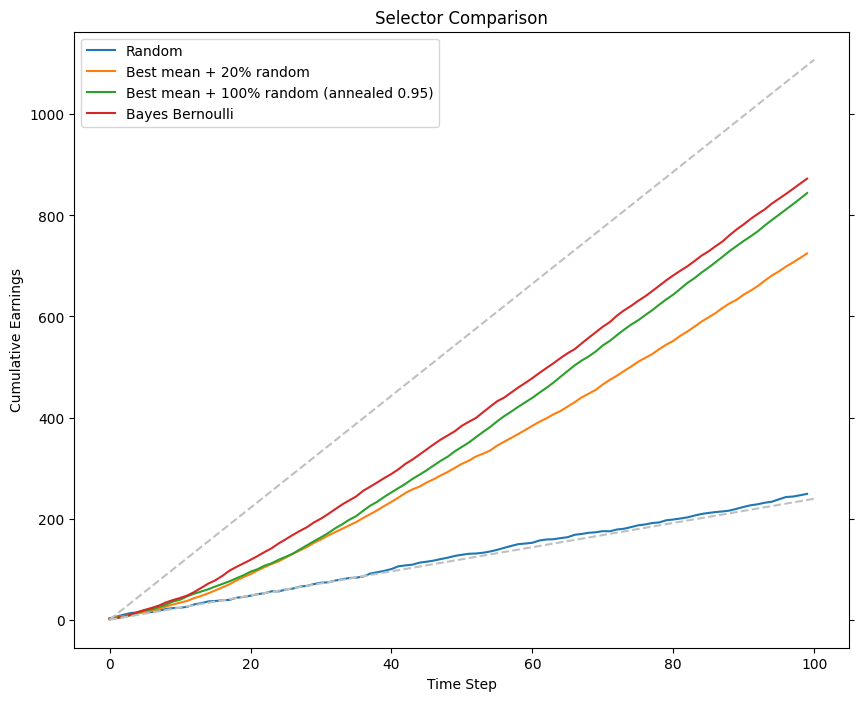

In [50]:
#
# Construct your Bayesian selector, initialised as appropriate
#
#### YOUR CODE HERE ####
bayes_select = BayesBernoulliSelector(name="Bayes Bernoulli", K=num_levers, alpha_0=1, beta_0=1)

# List of selectors to test: you can add further examples (perhaps variants of bayes_select)
selectors = [rand_select,
             rand_best_mean_select,
             rand_best_mean_annealed_select,
             bayes_select]
#
# Assess the performance (may take a few seconds)
#
plot_performance(my_bandit, selectors, N=100, repeats=100, title='Selector Comparison')


# Follow-up: Repeat for the Gamma Distribution

`GammaBandit` is a $K$-armed bandit where the payout from each arm is a random sample from the Gamma distribution. This distribution has a fixed "shape" parameter $\alpha=5$, but each arm has its own "rate" parameter $\beta_k$.

You will need to consult some preferred reference here (there was a hint in the lecture...), to find out the correct conjugate prior for the rate $\beta_k$ and the corresponding posterior distribution statistics.

**Three points to note:**

1. You should base your selector on Thompson sampling again. Sampling from the posteriors will give you values for $\beta_k$, which then gives you an expected payout for each lever of $\frac{\alpha}{\beta_k}$ (the mean of a Gamma distribution). Given the sample, choose the lever with highest mean to again maximise expected payout.

2. The Gamma distribution is usually defined in terms of $\alpha$ (its "shape" parameter) and $\beta$ (its "rate" parameter). The`scipy.stats` module parameterises the Gamma distribution in terms of `a` ($\alpha$) and `scale`, the latter which is $1/\beta$.

3. The `GammaBandit` is particularly mean! Quite possibly (with the default random seed), only the Bayesian Selector algorithm will be able to make a profit after 100 pulls.

## Insert Your Code Below ...


In [51]:
# Write your BayesGammaSelector class here
        
# I will post a specimen example class later in the lab (which will have been loaded earlier)

#### YOUR CODE HERE ####

class BayesGammaSelector(setup.Selector):
    
    def __init__(self, name, K, alpha=5, beta_0=1, lambda_0=1):
        super().__init__(name, K)
        self._alpha = alpha  # Fixed shape parameter for the Gamma distribution
        self._beta_0 = beta_0  # Prior shape parameter for the rate (Gamma prior)
        self._lambda_0 = lambda_0  # Prior rate parameter for the rate (Gamma prior)
        self.reset_state()

    def reset_state(self):
        # Initialize the posterior parameters for each arm (Gamma distribution for rate parameter)
        self._beta = np.full(self.K, self._beta_0)  # Rate prior parameter
        self._lambda = np.full(self.K, self._lambda_0)  # Rate prior parameter

    def update_state(self, lever, payout):
        # Update the posterior distribution for the chosen arm
        self._beta[lever] += 1  # Increment the success count
        self._lambda[lever] += payout  # Sum of observed payouts

    def lever_select(self):
        # Sample from the posterior Gamma distribution for each arm
        sampled_betas = np.random.gamma(self._beta, 1 / self._lambda)  # We use 1 / rate for scale
        # Compute the expected payout for each arm: expected payout is alpha / beta (mean of Gamma)
        expected_payouts = self._alpha / sampled_betas
        # Choose the arm with the highest expected payout
        lever = np.argmax(expected_payouts)
        return lever


Final Earnings
Â£-618.15 <- Random
Â£-119.21 <- Best mean + 20% random
Â£-15.39 <- Best mean + 100% random (annealed 0.95)
Â£64.33 <- Bayes Gamma
Â£-608.61 <- Bayes Bernoulli


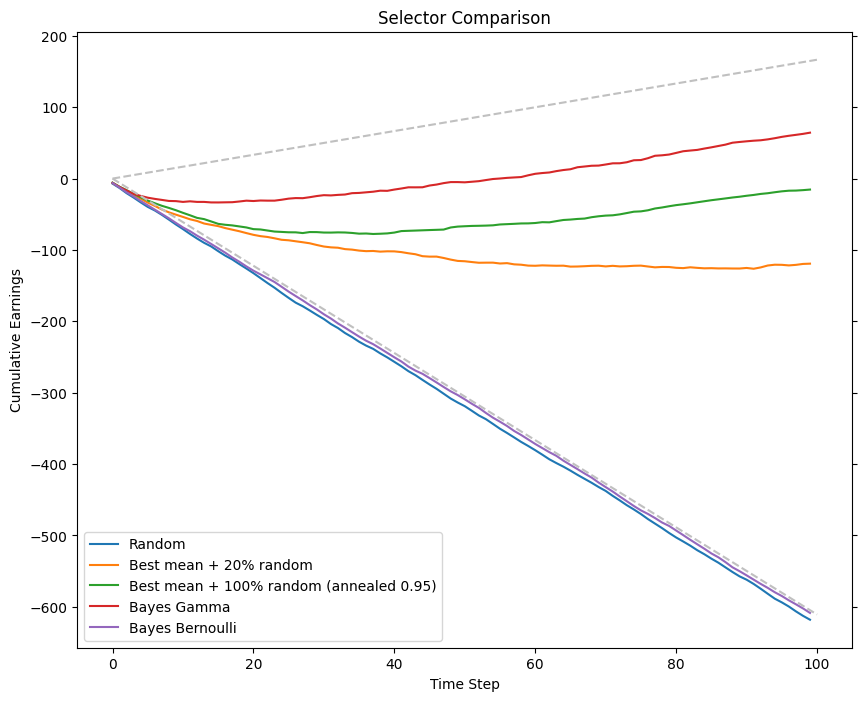

In [52]:
# Create new bandit
#
# Gamma bandit with default alpha=5
#
alpha = 5
gamma_bandit = setup.GammaBandit(num_levers, shape=alpha, seed=seed)

#### YOUR CODE HERE ####

bayes_gamma_select = BayesGammaSelector(name="Bayes Gamma", K=num_levers, alpha=5, beta_0=1, lambda_0=1)


# List of selectors to test: you can add further examples,
# or re-define the earlier "rand" ones
#
selectors = [rand_select,
             rand_best_mean_select,
             rand_best_mean_annealed_select,
             bayes_gamma_select,
             bayes_select]
#
plot_performance(gamma_bandit, selectors, N=100, repeats=100,
                 title='Selector Comparison')
